# Project: Simulate the Options Chain for Micron `Call` Options
This project will test the ability of students to compute the premium of [American-style](https://en.wikipedia.org/wiki/Option_style) `call` options contracts. We'll compare student-simulated prices with contract prices observed in the market for [Micron Technology](https://finance.yahoo.com/quote/MU) (ticker symbol `MU`).

## Learning objectives
* __Prerequisites__: Load the options pricing data for `MU 62-DTE call` contracts for all listed strike prices.
* __Objective__: Compute the premium as a function of the strike price for `MU` call options using the Binomial lattice model
    * `TODO`: Iterate through `dataset` and compute the `call` contract premiums
        * `TODO`: Visualize the premium versus the strike price
        * `TODO`: Are any `call` options mispriced? If so, is there a systematic trend visible for the mispriced contracts?

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites
In this project, we will use options chain data for [Micron Technologies](https://www.google.com/finance/quote/MU:NASDAQ?sa=X&ved=2ahUKEwj25cm70byEAxWatokEHesdBYUQ3ecFegQIJhAX), ticker symbol `MU` to test the [Binomial lattice model of Cox, Ross, and Rubinstein](https://en.wikipedia.org/wiki/Binomial_options_pricing_model). We download this data from [Barchart. com](https://www.barchart.com/).
* Load the options pricing data for all the `62-DTE call` contracts by loading the entire dataset using the `MyOptionsChainDataSet()` function and filtering out the `call` contract data. Save the resulting `call` contract pricing information in the `dataset` variable:

In [2]:
dataset = MyOptionsChainDataSet() |> x-> filter(:Type=>y-> y=="Call", x) # load the dataset, select the Call contracts

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,32.5,0.5912,46.9,47.22,47.55,49.16,0,2,0.99881,0.6458,Call
2,35.0,0.5597,44.4,44.8,45.2,39.75,0,1,0.99364,0.8463,Call
3,37.5,0.5283,41.95,42.33,42.7,0.0,0,0,0.99303,0.784,Call
4,40.0,0.4969,39.5,39.9,40.3,46.57,0,24,0.98822,0.7904,Call
5,42.5,0.4654,36.9,37.35,37.8,43.15,0,1,0.99424,0.6253,Call
6,45.0,0.434,34.55,34.88,35.2,37.85,0,27,0.9936,0.5769,Call
7,47.5,0.4025,32.15,32.5,32.85,30.35,0,85,0.98231,0.6363,Call
8,50.0,0.3711,29.65,30.03,30.4,30.35,2,65,0.95655,0.7286,Call
9,55.0,0.3082,24.85,25.2,25.55,25.69,30,377,0.96381,0.5384,Call


## Objective: Compute the premium as a function of the strike price for `MU` call options
To start the premium calculation, set the parameters for this contract and then build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type, an instance of the `MyAmericanCallContractModel` type, and then use the `premium(...)` to compute the premium (price).
* Assume there are `365` days per year, and the contract has `T = 62 days` to expiration. The current share price of `MU` is $S_{o}$ = `79.50 USD/share`, and the risk-free-rate is `4.9%`.

In [3]:
Δt = (1/365); # natural time-scale is days
T = 62*Δt; # days to the expiration of the contract
Sₒ = 79.50; # initial share price of MU shares
r̄ = 0.049; # risk-free rate
h = 248; # number of levels of the tree, 4-points per day

Notice that we did not set a value for the implied volatility `IV` or the strike price `K` of the `call` contracts. These parameters vary from contract to contract, so we must extract them from the `dataset`.

### TODO: Iterate through the `dataset` and compute the `call` contract premiums
For each contract in `dataset,` get the `strike,` `IV,` `Bid,` and `Ask` values from `dataset,` and use these parameters (along with the current share price) to construct `MyAdjacencyBasedCRREquityPriceTree` and `MyAmericanPutContractModel` instances. 
* Use the `premium(...)` function to compute the premium (price) of each option contract in the `dataset.`
* Populate records in the `premium_table::DataFrame,` assuming we capture the strike `K,` `bid,` `ask,` the computed premium, and a `mispriced::Bool` field. The `mispriced::Bool` field holds a `true|false` value indicating if the predicted contract price lies within the range $\left(1-\delta\right)\cdot\text{Bid}\leq\mathcal{P}_{p}\leq\left(1+\delta\right)\cdot\text{Ask}$, where the error margin is taken to be $\delta\sim{1\%}$.
* `Technical issue`: there are missing `IV` values in the `dataset` (listed as `0` values), leading to `false positive` pricing errors. Check for this condition, and set the missing `IV` values to some small value $\epsilon\sim{0.001}$.

In [4]:
number_of_contracts = nrow(dataset);
premium_table = DataFrame();
for i ∈ 1:number_of_contracts

    # get the data for contract i
    K = dataset[i,:Strike]
    IV = dataset[i,:IV];
    bid = dataset[i,:Bid]
    ask = dataset[i,:Ask]

    # build the tree for contract i
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = r̄, T = T, σ = IV)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

    # build the contract model for contract i
    contractmodel = build(MyAmericanCallContractModel, (
        K = K, sense = 1, copy = 1));

    # compute the premium for contract i
    𝒫 = premium(contractmodel, treemodel);

    # populate the data frame -
    row = (
        K = K,
        bid = bid,
        ask = ask,
        computed = 𝒫,
        mispriced = !(((0.99)*bid <= 𝒫) && (𝒫 <= (1.01)*ask))
    );
    push!(premium_table, row);
end
premium_table

Row,K,bid,ask,computed,mispriced
,Float64,Float64,Float64,Float64,Bool
1,32.5,46.9,47.55,47.27,false
2,35.0,44.4,45.2,44.84,false
3,37.5,41.95,42.7,42.37,false
4,40.0,39.5,40.3,39.94,false
5,42.5,36.9,37.8,37.39,false
6,45.0,34.55,35.2,34.91,false
7,47.5,32.15,32.85,32.53,false
8,50.0,29.65,30.4,30.38,false
9,55.0,24.85,25.55,25.22,false


#### TODO: Visualize the premium versus the strike price

`Unhide` the code cell below to see how we plot the strike price versus the computed (and observed) contract premium `MU` call contracts.

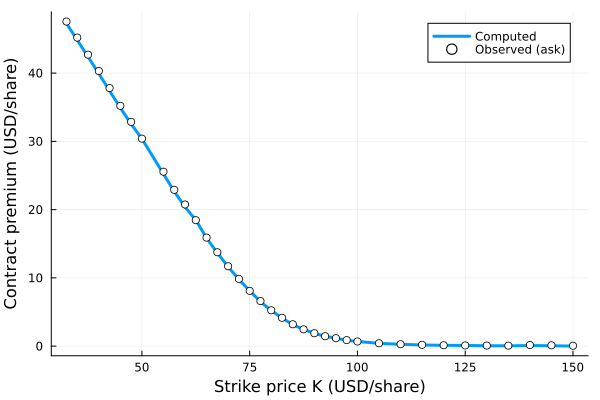

In [5]:
plot(premium_table[:,:K], premium_table[:,:computed], label="Computed", lw=3);
scatter!(premium_table[:,:K],premium_table[:,:ask], label="Observed (ask)", msc="black", mc="white")
xlabel!("Strike price K (USD/share)", fontsize = 18)
ylabel!("Contract premium (USD/share)", fontsize = 18)

### TODO: Are any of the `MU call` options mispriced at a $\delta\sim\text{1\%}$ error tolerance?
If we assume the `CRR` model estimated option price is correct, given the market values of the implied volatility `IV` and the strike price `K`, how many of the options in the `dataset` are mispriced?
* In the calculation above, stored in the `premium_table::DataFrame` variable, the `mispriced` field holds a `true|false` value calculated from the evaluation of the statement: $\left(1-\delta\right)\cdot\text{Bid}_{i}\leq\mathcal{P}_{p, i}\leq\left(1+\delta\right)\cdot\text{Ask}_{i}$, where $\text{Bid}_{i}$ denotes the `Bid` price and $\text{Ask}_{i}$ represents the `Ask` price for option $i$, and $\mathcal{P}_{p, i}$ denotes the premium for `put` contract $i$ in `dataset`.

In [6]:
number_of_mispriced_options = filter(:mispriced=> x-> x==true,premium_table) |> x-> nrow(x)
println("Number of mispriced contracts $(number_of_mispriced_options) of $(number_of_contracts)")

Number of mispriced contracts 0 of 37


Look at the data for any mispriced contracts using the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl).

In [7]:
if (number_of_mispriced_options != 0)
    mispriced_contracts = filter(:mispriced=> x-> x==true,premium_table)
else
    println("No call contracts were mispriced")
end

No call contracts were mispriced


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.